In [1]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

In [2]:
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit
import warnings 

In [3]:
warnings.filterwarnings ("ignore")

# Parte I

## 1

In [219]:
# Cargo el excel de la EPH
eph_hogar = pd.read_excel("usu_hogar_T121.xlsx")
eph_indiv = pd.read_excel("usu_individual_T121.xlsx")

In [220]:
# Me quedo solo con los aglomerados de CABA y GBA
eph_hogar.drop(eph_hogar[(eph_hogar['AGLOMERADO'] != 32) & (eph_hogar["AGLOMERADO"] != 33)].index, inplace = True)
eph_hogar.reset_index(inplace = True, drop = True)
eph_indiv.drop(eph_indiv[(eph_indiv['AGLOMERADO'] != 32) & (eph_indiv["AGLOMERADO"] != 33)].index, inplace = True)
eph_indiv.reset_index(inplace = True, drop = True)

## 2

In [221]:
# Junto la eph de hogares y individuos por la columna CODUSU, el suffixes = ("", "_y") es para que distinga las columnas
#repetidas en ambos dataframes colocandolo el sufijo "y" a los nombres de las columnas de la eph_indiv
eph = eph_hogar.merge(eph_indiv, on = "CODUSU", suffixes = ("", "_y") , how = "outer")
eph = eph[eph.columns.drop(list(eph.filter(regex='_y')))]
# Junto la eph de hogares y individuos por las columnas CODUSU y NRO_HOGAR, el suffixes = ("", "_y") es para que distinga las columnas
#repetidas en ambos dataframes colocandolo el sufijo "y" a los nombres de las columnas de la eph_indiv
#eph = eph_hogar.merge(eph_indiv, on = ["CODUSU", "NRO_HOGAR"], suffixes = ("", "_y") , how = "outer")
#eph = eph[eph.columns.drop(list(eph.filter(regex='_y')))]

## 3

In [222]:
def limpiar_eph(eph):

    '''
        función para limpiar la eph
        input:
            eph: Variable que tenga almacenada la eph sin limpiar

        output:
            eph: Variable que tiene almacenada la eph limpia
    '''
    
    eph.dropna(thresh = 1, inplace = True) # Si tiene todos NA, la fila se va
    
    eph.dropna(thresh = 1, axis = "columns", inplace = True) # Si la columna tiene todos NA, la columna se va
    
    try:
        # Si no lo defino como uno me dropea un montón de filas que tienen NaN
        eph.PP08D1 = eph.PP08D1.fillna(0)
        eph.PP08F2 = eph.PP08F2.fillna(0)
        # dropeo observaciones con valores que no tienen sentido. CH06 = edad, PP08D1, P21, P47T, ITF y IPCF son 
        # todas variables de ingresos, no pueden ser menores a 0
        eph.drop(eph[(eph["CH06"] < 0) | (eph["PP08D1"] < 0) | (eph["P21"] < 0) | 
                     (eph["P47T"] < 0) | (eph["ITF"] < 0) | (eph["IPCF"] < 0) | 
                     (eph["PP08F2"] < 0)].index, inplace = True)
        eph["CH14"].fillna(99, inplace = True) #Muchos no respondieron entonces reemplazamos los missing por 99.
        eph.fillna(0, inplace = True) # Relleno todos con 0 los missing de las columnas que representan subcategorías en
        #las que solo respondieron algunos. 
        #Para las siguientes variables dummys hay entre 15 y 20 observaciones para las que toma valor 9, es decir Ns/Nr.
        #Como son pocas observaciones y siempre las mismas, optamos por eliminarlas. 
        eph.drop(eph[(eph["V1"] == 9 ) | (eph["V2"] == 9) | (eph["V3"] == 9) | (eph["V4"] == 9) | (eph["V5"] == 9) | 
                     (eph["V6"] == 9 ) | (eph["V7"] == 9) | (eph["V8"] == 9) | (eph["V9"] == 9) | (eph["V10"] == 9) | 
                     (eph["V11"] == 9) | (eph["V12"] == 9) | (eph["V13"] == 9) | (eph["V14"] == 9) | (eph["V15"] == 9) |
                     (eph["V16"] == 9) | (eph["V17"] == 9) | (eph["V18"] == 9) | (eph["V19_A"] == 9) | 
                     (eph["V19_B"] == 9)].index, inplace = True)
        eph.reset_index(inplace = True, drop = True)  
    except:
        print("No se encontró alguna columna, revisar")        

In [223]:
limpiar_eph(eph)

## 4

In [224]:
# Proporción de menores de edad en el hogar
eph['Prop_menores'] = 0
eph['menor_de_edad'] =eph["CH06"].apply(lambda x: 1 if x < 18 else 0)
eph['menor_de_edad']
eph["menores"]= eph["menor_de_edad"].groupby(eph["CODUSU"]).transform("sum")
eph['Prop_menores'] = eph['menores']/eph['IX_TOT']



0       0.500000
1       0.500000
2       0.500000
3       0.500000
4       0.000000
          ...   
3314    0.000000
3315    0.000000
3316    0.333333
3317    0.333333
3318    0.333333
Name: Prop_menores, Length: 3319, dtype: float64

In [225]:
eph.drop("menor_de_edad", axis = 1, inplace = True)
eph.drop("menores", axis = 1, inplace = True)

In [226]:
#Proporcion de miembros del hogar que asisten o asistieron a un establecimiento
#educativo privado 

eph['educ_privada']= 0

for i in eph.index:
    if eph["CH10"][i] == 1 and eph["CH11"][i] == 2:
        eph.loc[i, 'educ_privada'] = 1
    elif eph["CH10"][i] == 2 and eph["CH11"][i] == 2:
        eph['educ_privada'][i] = 1
    else:
        eph['educ_privada'][i] = 0



count    3319.000000
mean        0.107864
std         0.310255
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: educ_privada, dtype: float64

In [227]:
eph["educ_privada_hogar"]= eph["educ_privada"].groupby(eph["CODUSU"]).transform("sum")
eph["prop_educ_privada_hogar"]= eph["educ_privada_hogar"]/eph['IX_TOT']


count    3319.000000
mean        0.095917
std         0.181742
min         0.000000
25%         0.000000
50%         0.000000
75%         0.166667
max         1.000000
Name: prop_educ_privada_hogar, dtype: float64

In [228]:
eph.drop("educ_privada_hogar", axis = 1, inplace = True)
eph.drop('educ_privada', axis = 1, inplace = True)

## 5

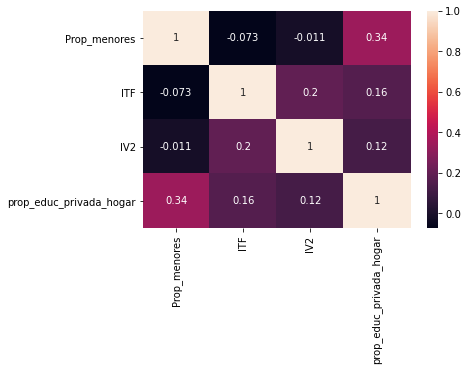

In [229]:
#Heatmap 
correlaciones = eph[["Prop_menores","ITF","IV2", "prop_educ_privada_hogar"] ].corr()
sns.heatmap(correlaciones, annot=True)
plt.show()


## 6

In [230]:
#Importamos la tabla de excel
tabla_adulto = pd.read_excel("tabla_adulto_equiv.xlsx", header = 3)
#Ajustamos el formato de la tabla 
tabla_adulto.dropna(axis = 1, inplace = True, thresh = 10)
tabla_adulto.dropna(inplace = True, thresh = 3)
tabla_adulto.reset_index(inplace = True, drop = True)
#Creamos la columna "adulto_equiv" como una columna de ceros
eph["adulto_equiv"] = 0
#Generamos una nueva columna llamada lista como una columna de ceros 
eph["lista"] = 0
#Iteramos por filas
#Para cada fila del data frame de acuerdo a la edad le indicamos que 
#la celda de la columna "lista" la complete con el número correspondiente 
#al índice de la tabla_adulto. 
#Por ejemplo, si la edad es menor a 30 entonces se asigna el numero 18 que es
#el índice de la fila de 18 a 29 años. 
for i in eph.index:
    if eph.loc[i, "CH06"] < 19:
        eph.loc[i, "lista"] = eph.loc[i, "CH06"]
    elif eph.loc[i, "CH06"] < 30:
        eph.loc[i, "lista"] = 18
    elif eph.loc[i, "CH06"] < 46:
        eph.loc[i, "lista"] = 19
    elif eph.loc[i, "CH06"] < 61:
        eph.loc[i, "lista"] = 20
    elif eph.loc[i, "CH06"] < 76:
        eph.loc[i, "lista"] = 21
    else:
        eph.loc[i, "lista"] = 22
#CH06 = edad, CH04 = Sexo (1 = varon y 2 = mujer)
#Para cada fila del dataframe si el individuo es varón entonces le indicamos que bajo 
#la columna "adulto_equiv" coloque la siguiente celda de tabla_adulto: 
# Fila: el índice que esta guardado en la columna "lista" en el df eph. 
# Columna: Varones 
#idem para las mujeres
#De este modo se obtienenn los valores de adulto equivalente de cada persona según 
#su sexo y edad
for i in eph.index:
    if eph.loc[i, "CH04"] == 1:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Varones"]
    elif eph.loc[i, "CH04"] == 2:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Mujeres"]
#Eliminamos la columna "lista"
eph.drop("lista", axis = 1, inplace = True)
#Realizamos un groupby: para cada hogar sumamos "adulto_equiv"
ad_equiv_hogar = eph[["CODUSU", "adulto_equiv"]].groupby("CODUSU").sum()
ad_equiv_hogar.reset_index(inplace = True)
#cambiamos los nombres de las columnas
ad_equiv_hogar.columns = ["CODUSU", "ad_equiv_hogar"]
#agregamos la columnna "ad_equiv_hogar" al df eph
eph = eph.merge(ad_equiv_hogar, on = "CODUSU", how = "outer")

# Dividimos la muestra de la EPH en gente que no respondio ingresos totales familiares (ITF) y los que sí.
norespondieron = eph[eph["ITF"] == 0]
norespondieron.reset_index(inplace = True, drop = True)
respondieron = eph[eph["ITF"] != 0]
respondieron.reset_index(inplace = True, drop = True)

# Le agregamos la columna ingreso_necesario que nos indica según el hogar, cuánto debe ganar para no ser
# considerado pobre
ingreso_adulto_min = 18914
respondieron["ingreso_necesario"] = ingreso_adulto_min * respondieron["ad_equiv_hogar"]

## 7

In [231]:
# Creamos una columna dummy, que dice si el individuo es pobre o no. Depende de si sus ingresos
# son mayores a ingreso_necesario
respondieron["pobre"] = (respondieron["ITF"] < respondieron["ingreso_necesario"]).astype(int)

## 8

In [232]:
# Agarramos solo GBA, porque pide calcularlo para GBA
eph_gba = respondieron[respondieron["AGLOMERADO"] == 33]

#Agrupamos por hogar con el groupby("CODUSU") y nos quedamos con el PONDIH, y la columna de pobre,
#para las cuales calculamos la media
eph_gba = eph_gba.groupby("CODUSU").agg({"PONDIH":"mean","pobre":"mean"})

# Armamos la suma de los PONDIH para pobres y para todos
pondih_pobres = eph_gba[eph_gba["pobre"] == 1].apply({"PONDIH":"sum"})
pondih_total = eph_gba.apply({"PONDIH":"sum"})

# Por último, los dividimos para así obtener la tasa de hogares pobres
pondih_pobres/pondih_total

PONDIH    0.365065
dtype: float64

Por lo tanto, la tasa de hogares bajo la liea de pobreza para el GBA es del 36,5%. Por su parte, para el periodo que estamos analizando el Indec reporta que el porcentaje de hogares por debajo de la línea de pobreza (LP) alcanzó el 31,2%; en los cuales reside el 40,6% de las personas.

# Parte II

## 1

In [233]:
def evalua_metodo(X_train, X_test, y_train, y_test, modelo, parametro=1.0):
    '''
    Función que reporta métricas de evaluación de un modelo a elección.
    
    input:
        X_train: X de entrenamiento.
        X_test: X de evaluación.
        y_train: Y de entrenamiento.
        y_test: Y de evaluación.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").
        parametro: Parámetro de regularización de los modelos. Por default = 1.0
        n: Parámetro para definir la catnidad de n-neighbours en KNN. Por default = 5.
        
    output:
        Df con las columnas: (modelo, ecm, parámetro, accuracy, matriz_confusion, auc)
        coe: En el caso de un modelo "Lasso", se define una variable global con los coeficientes de las variables X.
        
    '''
    ev_modelo = pd.DataFrame(columns=["modelo", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    # Filtro para distintos modelos.
    pob = LogisticRegression(max_iter = 5000, fit_intercept = False)
    if modelo == "Lineal":
        pob = LinearDiscriminantAnalysis()
    elif modelo == "KNN":
        pob = KNeighborsClassifier(n_neighbors = int(parametro))
    elif modelo == "Logit":
        pob = LogisticRegression(max_iter = 5000, fit_intercept = False)
    elif modelo == "Lasso":
        pob = LogisticRegression(penalty = "l1", max_iter = 5000, 
                                 fit_intercept = False, solver = "liblinear", C = parametro)
    elif modelo == "Ridge":
        pob = LogisticRegression(penalty = "l2", max_iter = 5000, 
                                 fit_intercept = False, solver = "liblinear", C = parametro)
    elif modelo == "ElasticNet":
        pob = LogisticRegression(penalty = "elasticnet", max_iter = 5000, 
                                 fit_intercept = False, solver = "saga", C = parametro)
    elif modelo == "CART":
        pob = DecisionTreeClassifier(max_depth = parametro)
    elif modelo == "SVM":
        pob = SVC(C = parametro,gamma='auto')
    elif modelo == "Bagging":
        pob = BaggingClassifier(base_estimator=SVC(C = parametro))
    elif modelo == "RandomForest":
        pob = RandomForestClassifier(max_depth = parametro)
    elif modelo == "Boosting":
        pob = GradientBoostingClassifier(learning_rate=1.0, max_depth = parametro)
    
    # Ajustamos el modelo        
    pob = pob.fit(X_train, y_train)     
    
    # Luego predecimos y con las X de evaluación.
    y_pred = pob.predict(X_test)
    
    if modelo != "SVM":
        # Probabilidad de que Y tome valor 1 segun el valor de X 
        y_pred_proba = pob.predict_proba(X_test)[:,1]

    #Valores de Accuracy
    accuracy_pob = accuracy_score(y_test, y_pred)

    #Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    if modelo != "SVM":
        #Valores de AUC
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)        
        
        #Curva ROC
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
        def ROC(roc):
            display.plot()  
            plt.plot([0, 1], [0, 1], color='red', linestyle='--')
            plt.show()
        ROC(display)

    # Error cuadrático medio
        
    ecm = mean_squared_error(y_pred, y_test)
    
    if modelo != "SVM":
        ev_modelo = ev_modelo.append({"modelo": modelo, "ecm": ecm, 
                                      "parámetro":parametro, "auc":auc,
                                      "accuracy":accuracy_pob, "fpr":fpr, "tpr":tpr}, ignore_index=True)
    elif modelo == "SVM":
        ev_modelo = ev_modelo.append({"modelo": modelo, "ecm": ecm, 
                                      "parámetro":parametro,
                                      "accuracy":accuracy_pob}, ignore_index=True)
    
    return ev_modelo

## 2

In [234]:
def cross_validation(x, y, k, modelo, parametro=1.0):
    '''
    Función que realiza validación cruzada con k iteraciones para cierto modelo.
    
    input:
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").
        parametro: Parámetro de regularización de los modelos. Por default = 1.0
        n: Parámetro para definir la catnidad de n-neighbours en KNN. Por default = 5.
        
    output:
        Df con las columnas: (modelo, particion, ecm, accuracy, matriz_confusion, auc, fpr, tpr)
        coe_cv: En el caso de un modelo "Lasso", se define un df global con los coeficientes de las variables X para las 
                k particiones por CV.
    '''
    # Creo el df ecms
    ecms = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    kf = KFold(n_splits = k, shuffle = True)
    
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        
        ev_modelo = evalua_metodo(x_train, x_test, y_train, y_test, modelo, parametro)
        
        ecms = ecms.append({"modelo":ev_modelo["modelo"].item(), 
                            "particion": i, "ecm":ev_modelo["ecm"].item(), 
                            "parámetro":parametro, "auc":ev_modelo["auc"].item(),
                            "accuracy":ev_modelo["accuracy"].item(), "fpr":ev_modelo["fpr"].item(),
                            "tpr":ev_modelo["tpr"].item()}, ignore_index=True)
        
        ecms = ecms.astype({"particion":int})
        
    return ecms 

## 3

In [235]:
def evalua_config(lista_parametros, x, y, k, modelo):
    '''
    Función que selecciona los hiperparámetros que menor ECM generen, mediante Cross-Validation.
    
    input:
        lista_parametros: lista de parámetros de regularización de los modelos que se van a usar para evaluar.
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").

    output:
        todos: df que contiene la información del modelo utilizado con las columnas
               (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr).
        ecms_avg: df que hace el promedio por parámetro, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        ev_modelo: df que contiene la información del mejor modelo elegido por ECM, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        coe_cvs: En el caso de un modelo "Lasso", se define un df global con los coeficientes de las variables X para las 
                k particiones por CV.
    '''
    # Defino data frames para usar después
    
    todos = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    # For loop que para cada parámetro corre Cross validation con k particiones.
    if modelo == "KNN":
        vecinos = [3,5,9,15,51]
        for i in vecinos:
            ecms = cross_validation(x, y, k, modelo, i)
            # ecmss es un df que guarda los resultados de todos los parámetros k veces.
            todos = todos.append(ecms)    
    else:
        for i in lista_parametros:
            ecms = cross_validation(x, y, k, modelo, i)
            # ecmss es un df que guarda los resultados de todos los parámetros k veces.
            todos = todos.append(ecms)

    # ecms_avg es un df que guarda los resultados de todos los parámetros haciendo un promedio de todos los ECM de ecmss
    ecms_avg = todos.groupby("parámetro").agg({"ecm":"mean", "modelo":"max", "auc":"mean",
                                               "accuracy":"mean"}).reset_index()
    
    min_ecm = np.Inf
    mejor_parametro = None
    # For loop que permite determinar el parámetro que tiene el menor ECM en promedio.
    for index, row in ecms_avg.iterrows():
        if row["ecm"] < min_ecm:
            min_ecm = row["ecm"]
            mejor_parametro = float(row["parámetro"])
    print("El minimo error es ", min_ecm, " y se da con un parametro de ", mejor_parametro)
    
    # Corro el modelo con el parámetro seleccionado con menor ECM en promedio.
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    ev_modelo = evalua_metodo(X_train, X_test, y_train, y_test, modelo, mejor_parametro)
    
    return (todos, ecms_avg, ev_modelo)

## 4

In [236]:
def evalua_multiples_metodos(lista_parametros, x, y, k):
    '''
    Función que corre múltiples métodos para diferentes parámetros los hiperparámetros que menor ECM generen, 
    mediante Cross-Validation.
    
    input:
        lista_parametros: lista de parámetros de regularización de los modelos que se van a usar para evaluar.
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.

    output:
        lista_todos: df que contiene la información de todos los modelos utilizados con las columnas
               (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr).
        lista_promedios: df que hace el promedio por parámetro de los diferentes modelos, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        lista_mejores: df que contiene la información de los mejores modelos elegido por ECM en los distintos modelos,
                       con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
    '''
    
    lista_todos = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    lista_promedios = pd.DataFrame(columns=["modelo", "parámetro", "ecm", "auc", "accuracy"])
    lista_mejores = pd.DataFrame(columns=["modelo", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    modelos = ["Lineal", "KNN", "Logit", "CART", "SVM", "Bagging", "RandomForest", "Boosting", "Lasso", "Ridge"]
    for modelo in modelos:
        todos, ecms_avg, ev_modelo = evalua_config(lista_parametros, x, y, k, modelo)
        lista_todos = lista_todos.append(todos)
        lista_promedios = lista_promedios.append(ecms_avg)
        lista_mejores = lista_mejores.append(ev_modelo)
        
    return (lista_todos, lista_promedios, lista_mejores)

# Parte III

## 1

In [237]:
# Eliminamos de ambas bases las columnas de ingresos
respondieron.drop(["PP08D1","PP08D4","PP08F1","PP08F2","PP08J1","PP08J2","PP08J3","P21","TOT_P12","P47T",
                   "V2_M","V3_M","V4_M","V5_M","V8_M","V9_M","V10_M","V11_M","V12_M","V18_M","V19_AM",
                   "V21_M","T_VI","ITF","IPCF","ingreso_necesario","ad_equiv_hogar","adulto_equiv","IX_MAYEQ10"],
                  axis = 1, inplace = True)
norespondieron.drop(["PP08D1","PP08D4","PP08F1","PP08F2","PP08J1","PP08J2","PP08J3","P21","TOT_P12","P47T",
                     "V2_M","V3_M","V4_M","V5_M","V8_M","V9_M","V10_M","V11_M","V12_M","V18_M","V19_AM",
                     "V21_M", "T_VI", "ITF", "IPCF", "ad_equiv_hogar", "adulto_equiv", "IX_MAYEQ10"],
                    axis = 1, inplace = True)
# Nos dimos cuenta tarde que faltan cambiar algunas para que no aparezcan NaN y dropear las de deciles
respondieron["CH14"].fillna(99, inplace = True) #Muchos no respondieron entonces reemplazamos los missing por 99. 
norespondieron["CH14"].fillna(99, inplace = True)
# innecesarios (con muy pocas o ninguna observación) o de ingreso 
respondieron.drop(["CH15_COD", "CH16_COD", "PP03C", "PP03D", "CODUSU"], axis = 1, inplace = True) 
respondieron.drop(["DECOCUR","RDECOCUR","GDECOCUR","ADECOCUR","PONDIIO","DECIFR","RDECIFR","GDECIFR",
                   "PONDII","PONDIH","PONDERA","ADECIFR","DECCFR","RDECCFR","GDECCFR","ADECCFR","DECINDR",
                   "RDECINDR","GDECINDR","ADECINDR","CH05"], axis = 1, inplace = True) # todas deciles
# innecesarios (con muy pocas o ninguna observación) o de ingreso 
norespondieron.drop(["CH15_COD", "CH16_COD", "PP03C", "PP03D", "CODUSU"], axis = 1, inplace = True) 
norespondieron.drop(["DECOCUR","RDECOCUR","GDECOCUR","ADECOCUR","PONDIIO","DECIFR","RDECIFR","GDECIFR",
                     "PONDII","PONDIH","PONDERA","ADECIFR","DECCFR","RDECCFR","GDECCFR",
                     "ADECCFR","DECINDR","RDECINDR","GDECINDR","ADECINDR","CH05"],
                    axis = 1, inplace = True) # todas deciles
respondieron.reset_index(inplace = True, drop = True)
norespondieron.reset_index(inplace = True, drop = True)

In [238]:
# Herramienta para poder utilizar variables categóricas en los modelos.
label_encoder = preprocessing.LabelEncoder()

# Creamos una copia del dataframe para luego recuperar las columnas que no son categóricas
respondieron_temp = respondieron.copy()
norespondieron_temp = norespondieron.copy()

# Le aplicamos la herramienta al df
respondieron = respondieron.apply(label_encoder.fit_transform)
norespondieron = norespondieron.apply(label_encoder.fit_transform)

# Volvemos a introducir las columnas no categóricas 
respondieron[["PP3E_TOT","PP3F_TOT","PP04B2","PP04B3_MES","PP04B3_ANO","PP04B3_DIA","PP05B2_MES",
              "PP05B2_ANO","PP05B2_DIA","PP11B2_MES","PP11B2_ANO","PP11B2_DIA","IX_TOT","IX_MEN10"]] = \
respondieron_temp[["PP3E_TOT","PP3F_TOT","PP04B2","PP04B3_MES","PP04B3_ANO","PP04B3_DIA",
                     "PP05B2_MES","PP05B2_ANO","PP05B2_DIA","PP11B2_MES","PP11B2_ANO","PP11B2_DIA",
                     "IX_TOT","IX_MEN10"]] 
norespondieron[["PP3E_TOT","PP3F_TOT","PP04B2","PP04B3_MES","PP04B3_ANO","PP04B3_DIA","PP05B2_MES",
                "PP05B2_ANO","PP05B2_DIA","PP11B2_MES","PP11B2_ANO","PP11B2_DIA","IX_TOT","IX_MEN10"]] = \
norespondieron_temp[["PP3E_TOT","PP3F_TOT","PP04B2","PP04B3_MES","PP04B3_ANO","PP04B3_DIA",
                       "PP05B2_MES","PP05B2_ANO","PP05B2_DIA","PP11B2_MES","PP11B2_ANO","PP11B2_DIA",
                      "IX_TOT","IX_MEN10"]]

#Agregamos la columna de 1 
respondieronx = respondieron.iloc[:, :-1]
respondieronx["inter"] = 1
norespondieron["inter"] = 1

## 2

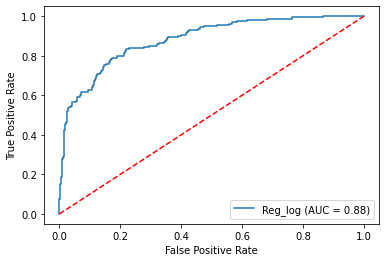

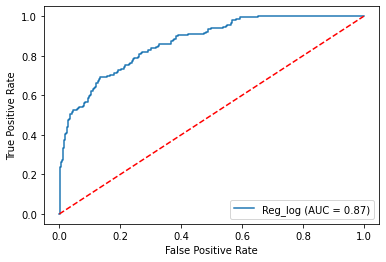

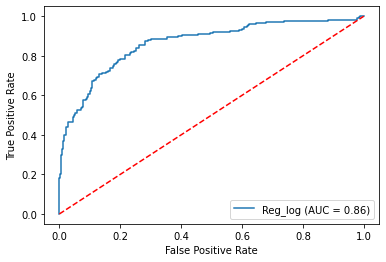

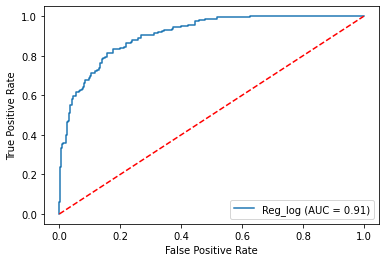

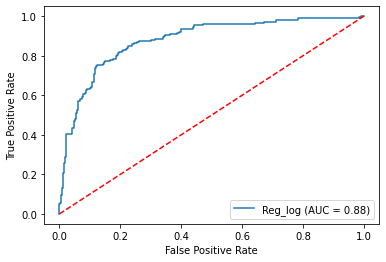

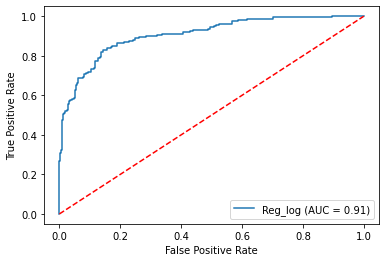

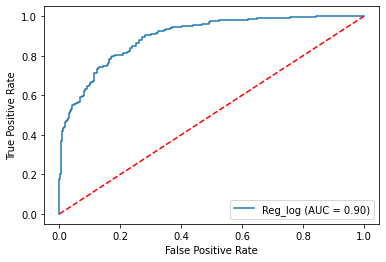

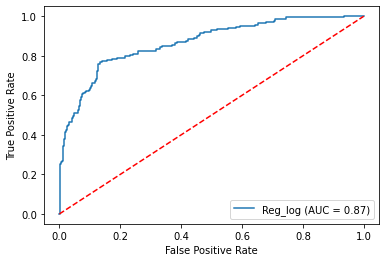

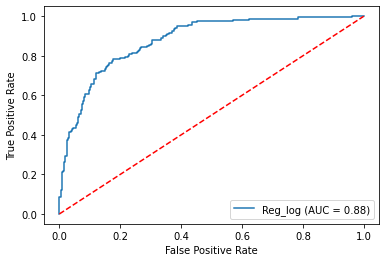

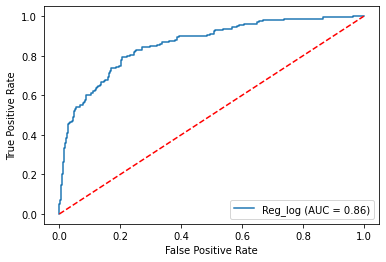

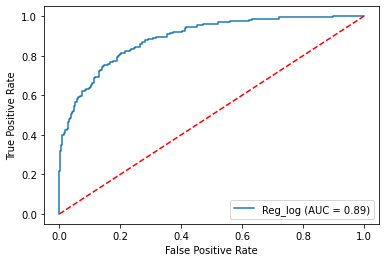

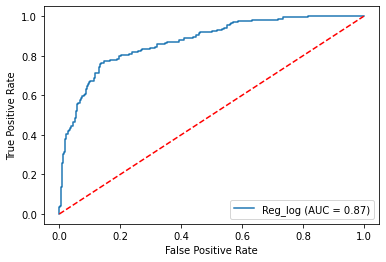

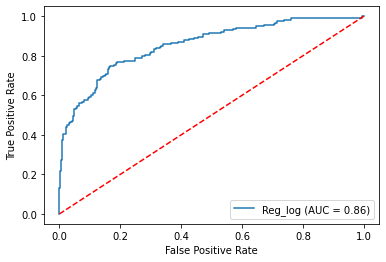

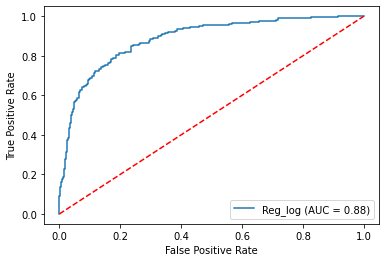

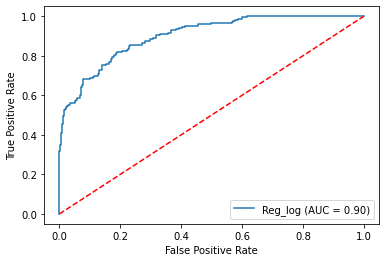

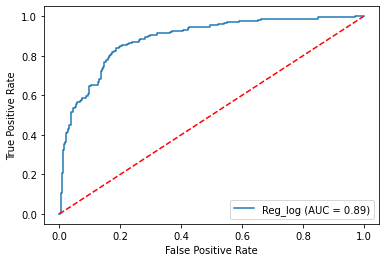

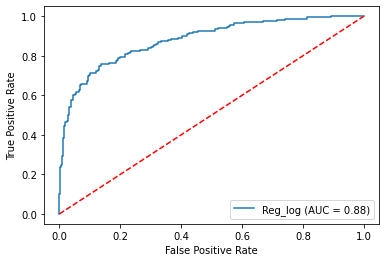

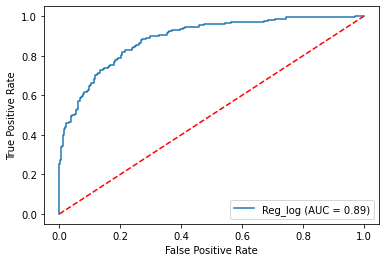

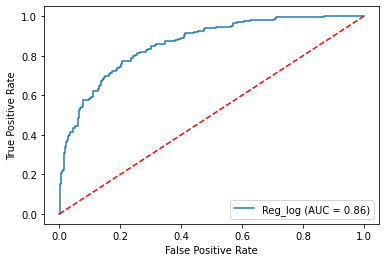

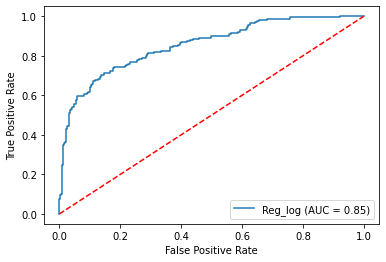

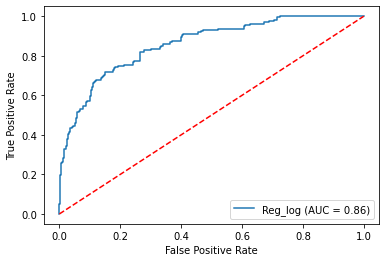

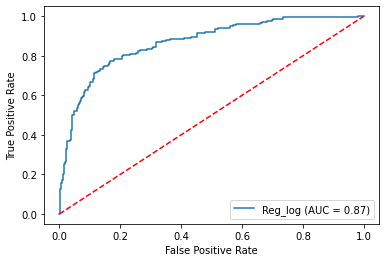

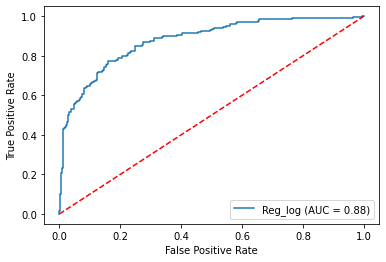

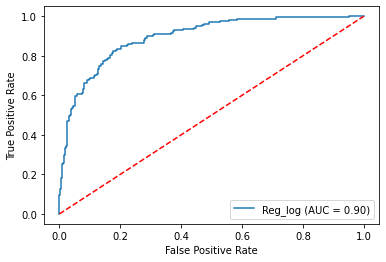

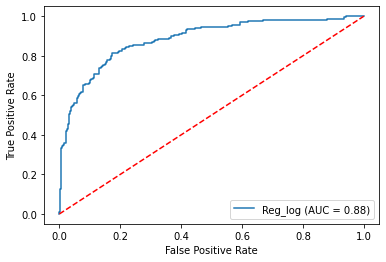

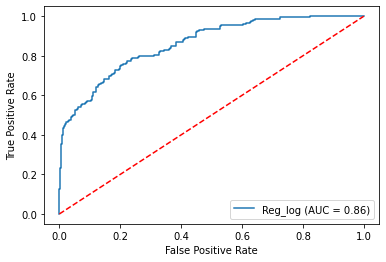

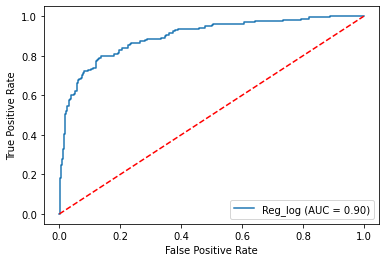

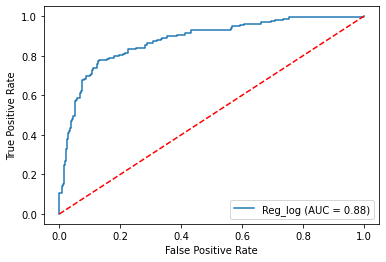

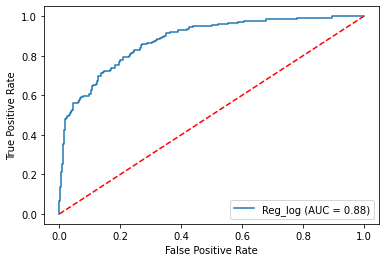

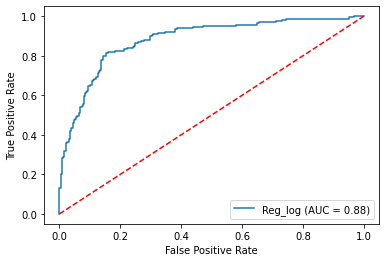

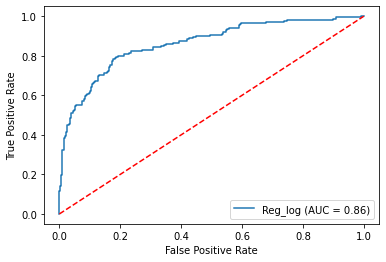

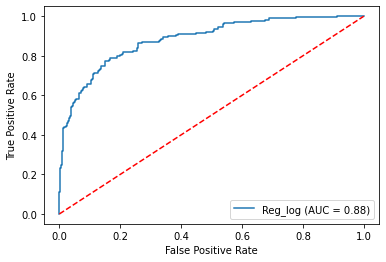

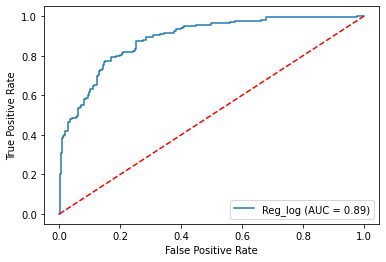

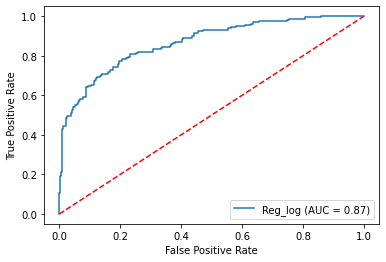

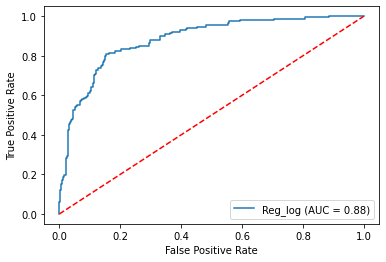

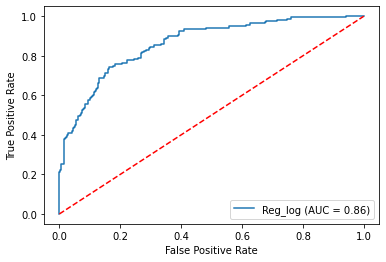

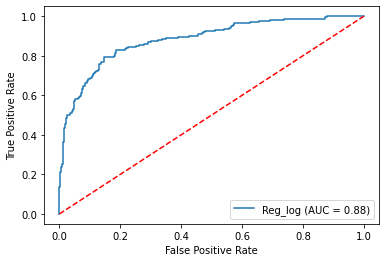

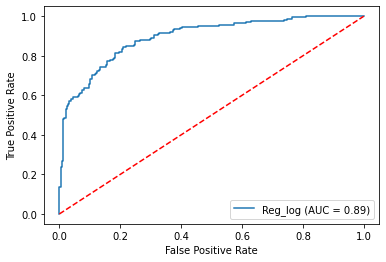

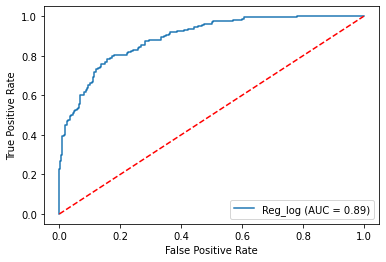

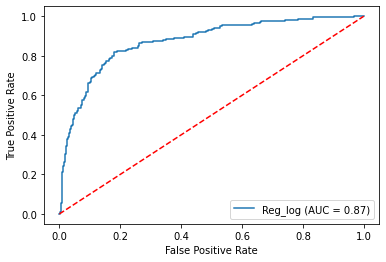

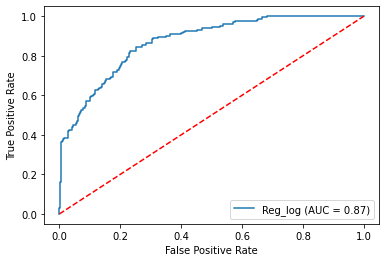

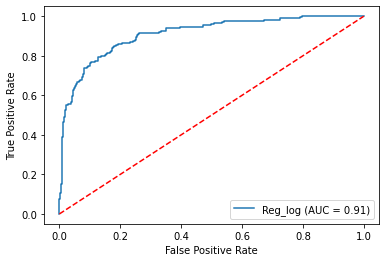

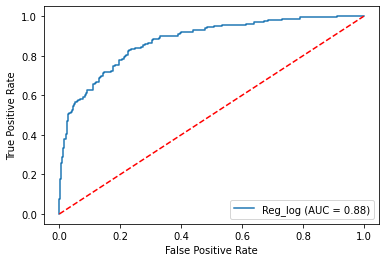

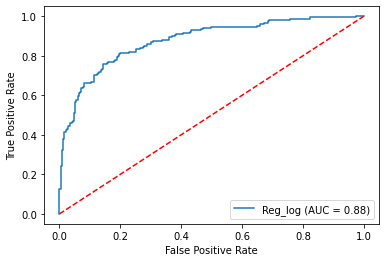

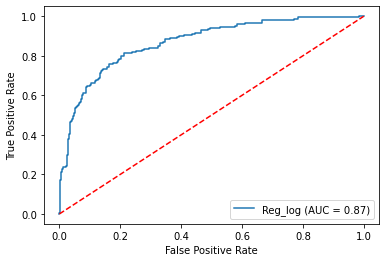

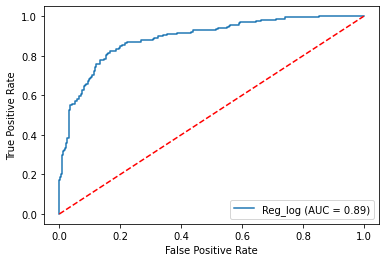

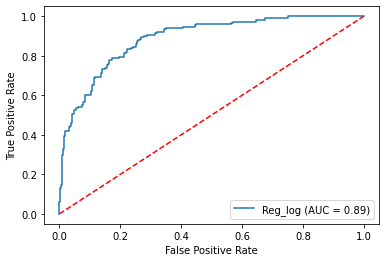

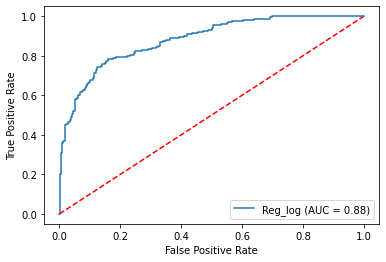

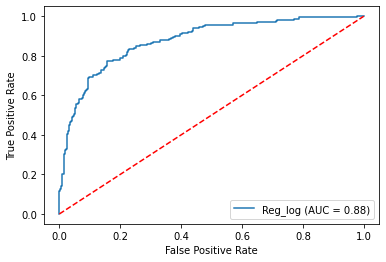

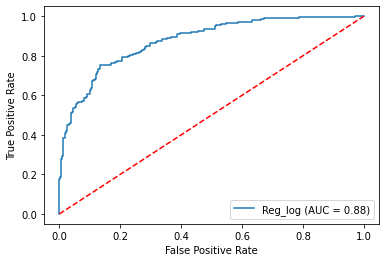

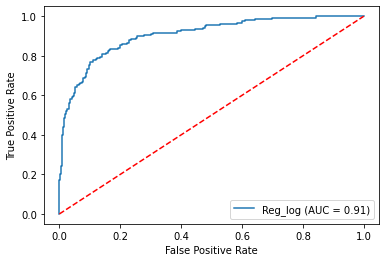

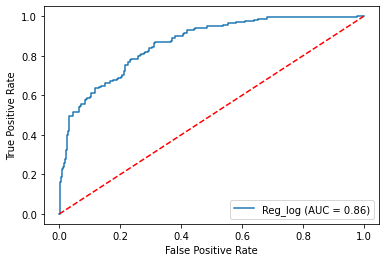

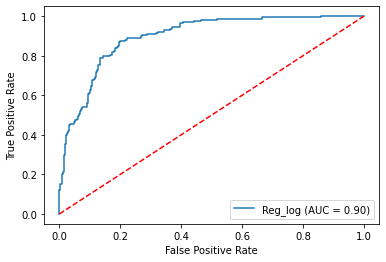

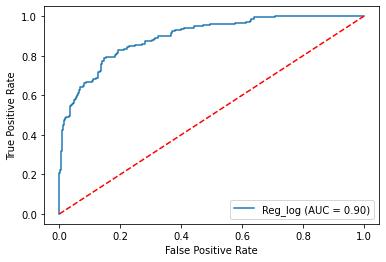

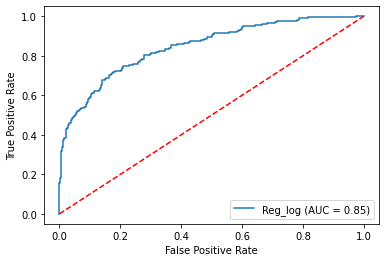

El minimo error es  0.17858363273453093  y se da con un parametro de  1000.0


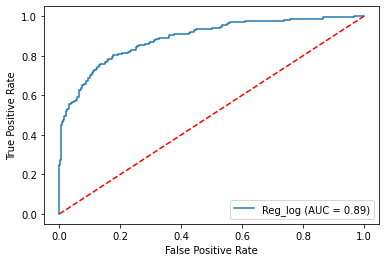

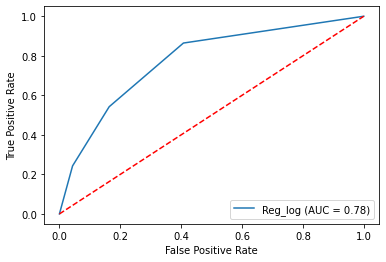

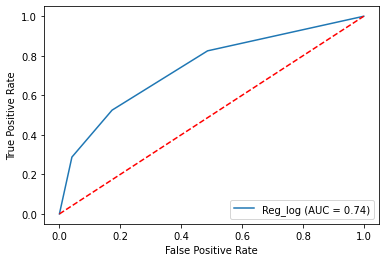

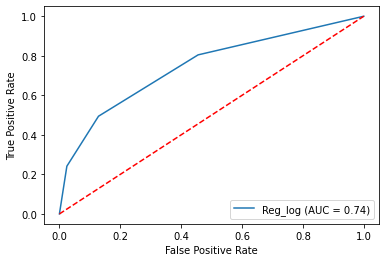

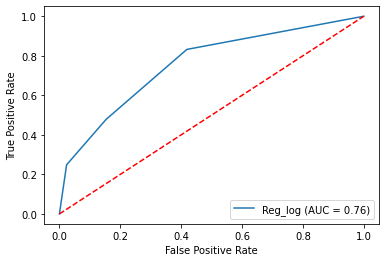

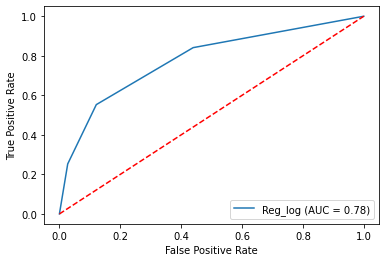

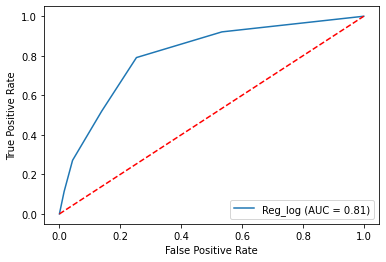

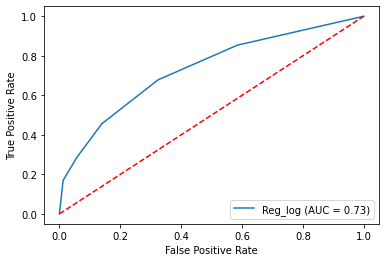

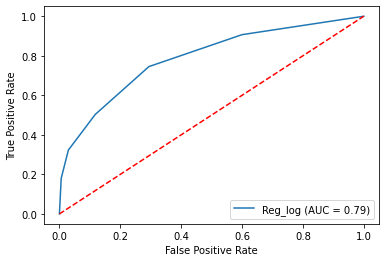

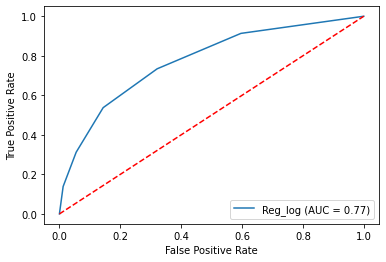

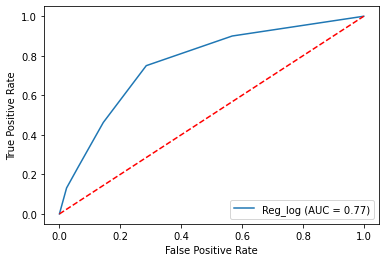

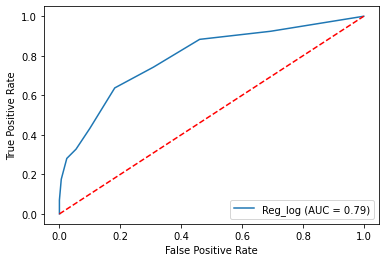

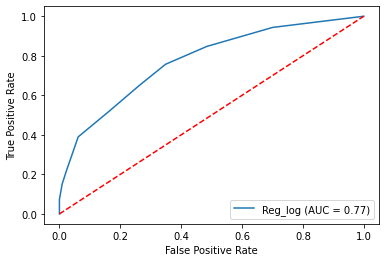

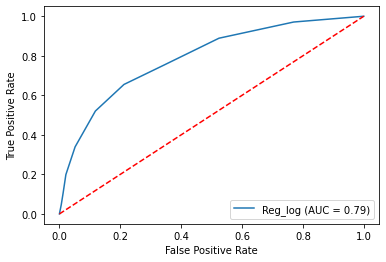

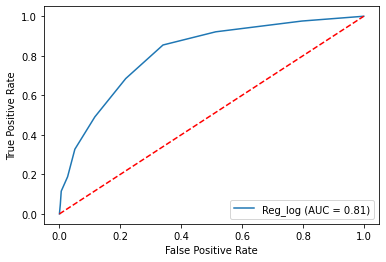

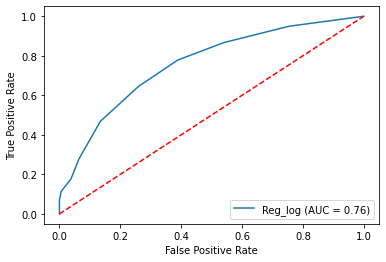

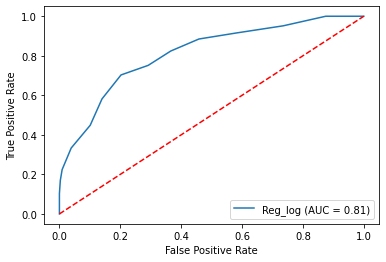

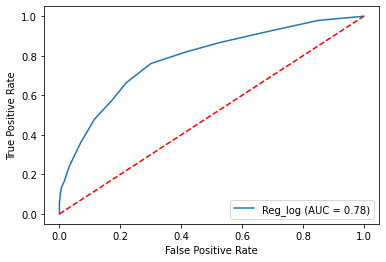

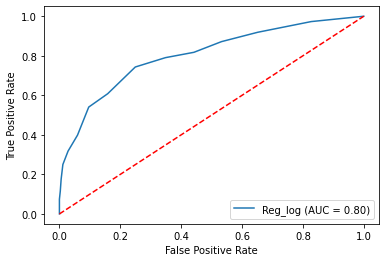

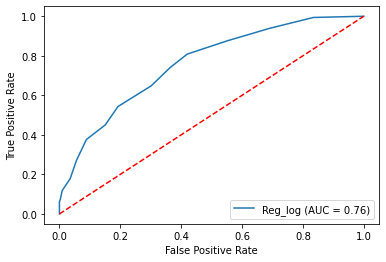

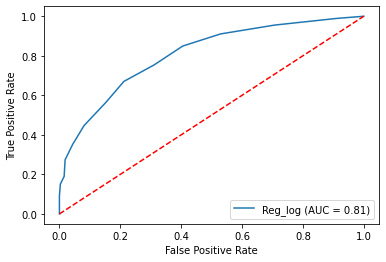

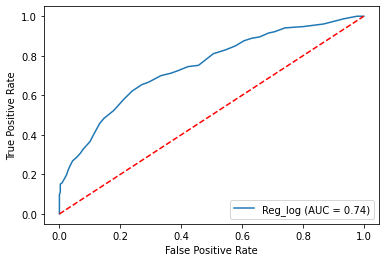

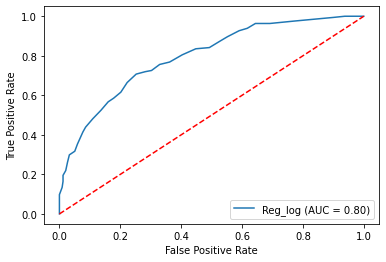

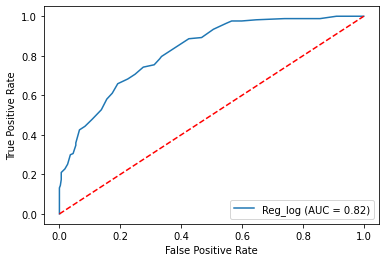

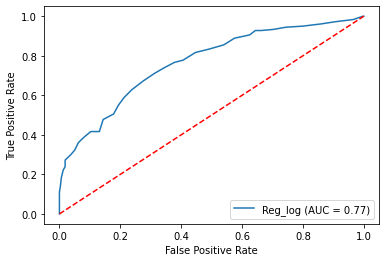

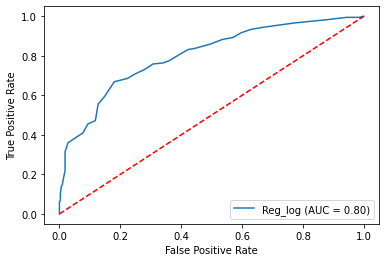

El minimo error es  0.24651896207584834  y se da con un parametro de  15.0


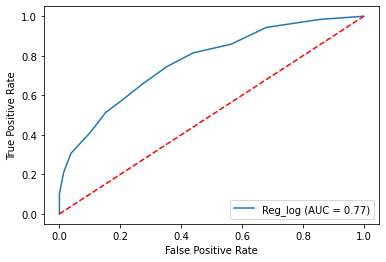

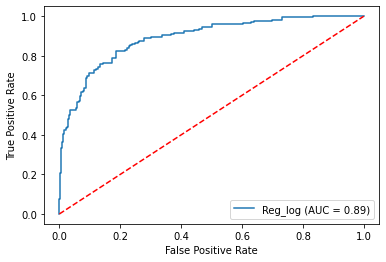

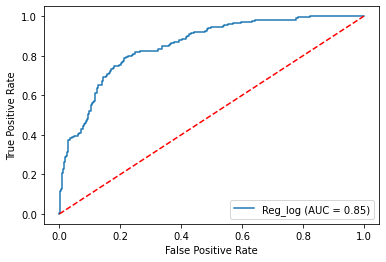

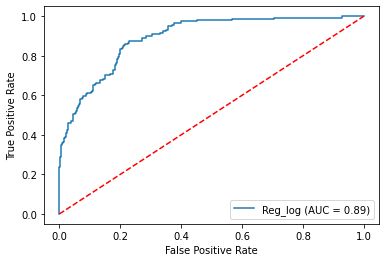

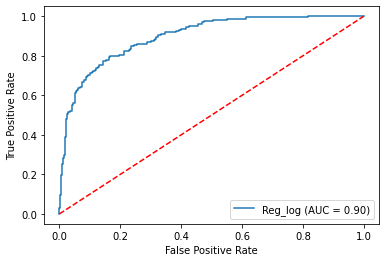

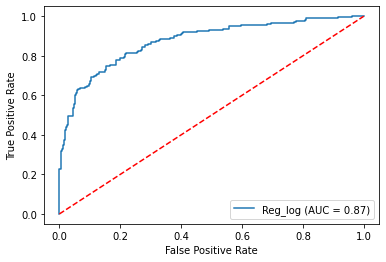

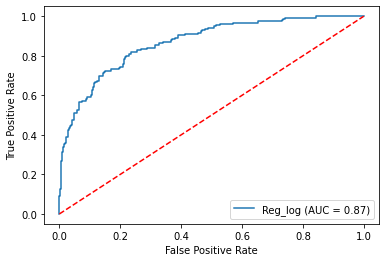

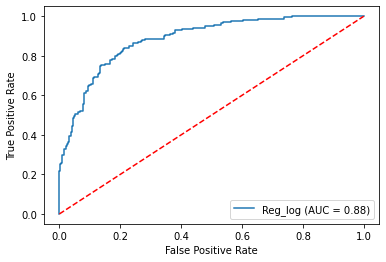

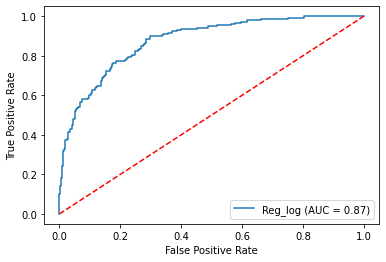

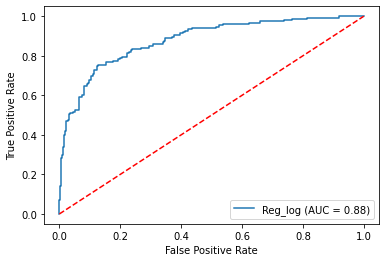

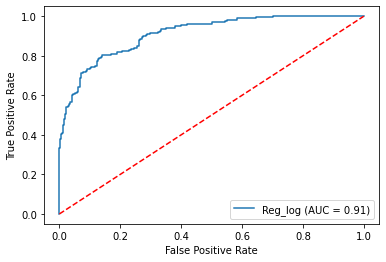

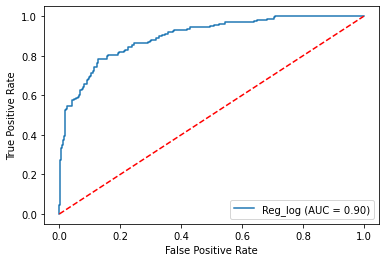

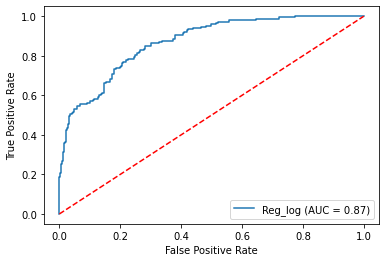

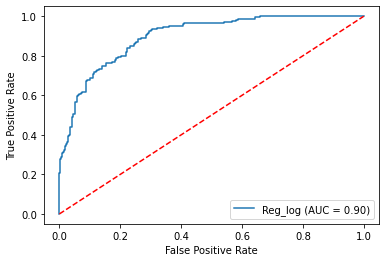

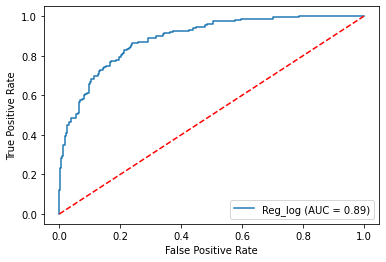

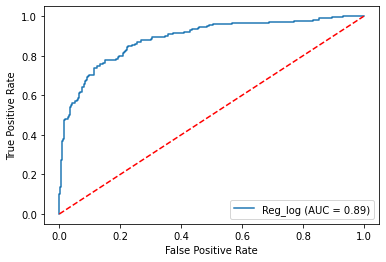

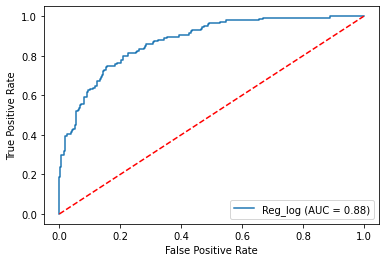

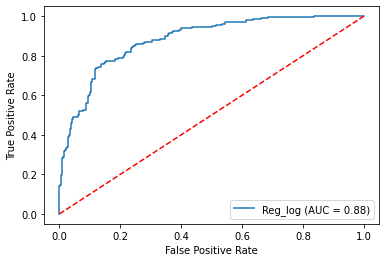

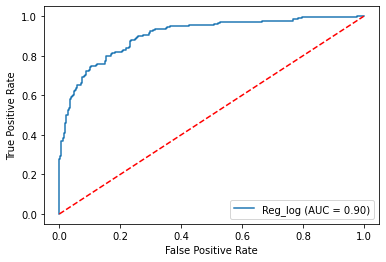

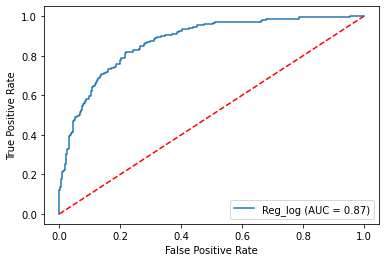

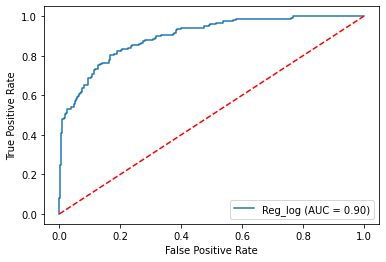

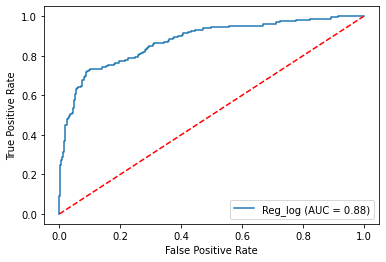

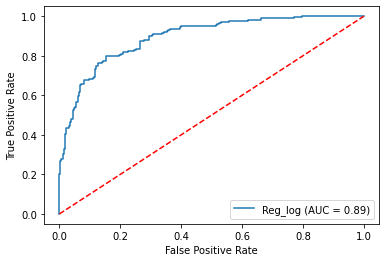

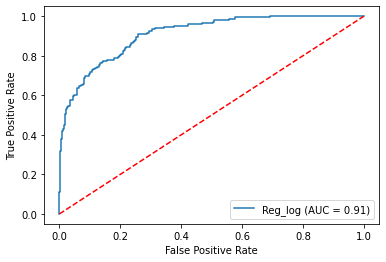

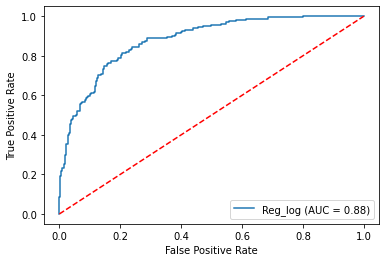

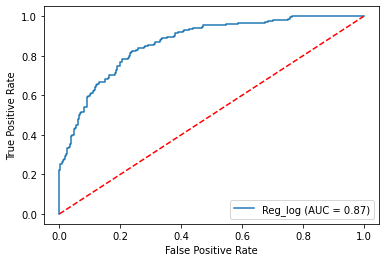

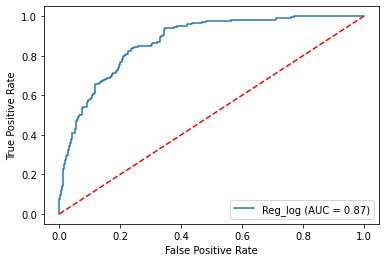

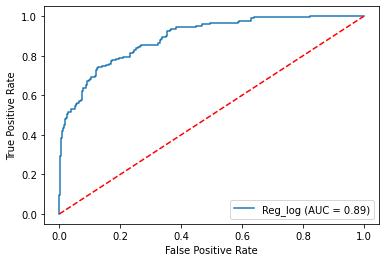

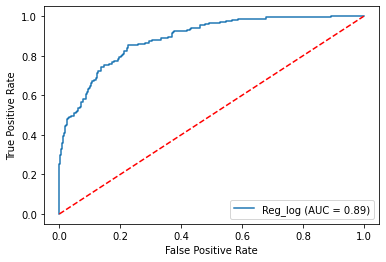

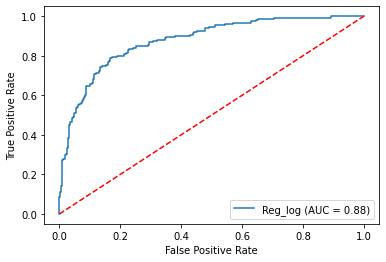

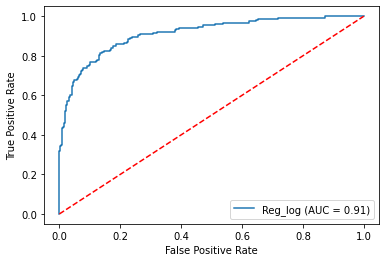

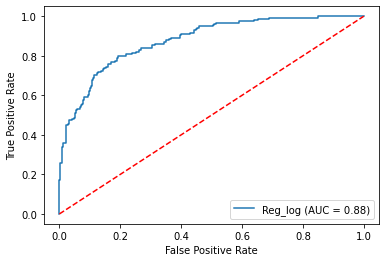

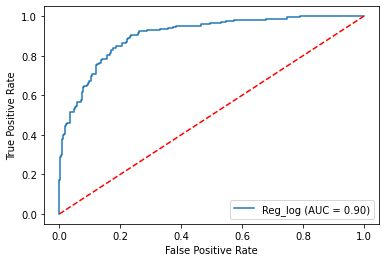

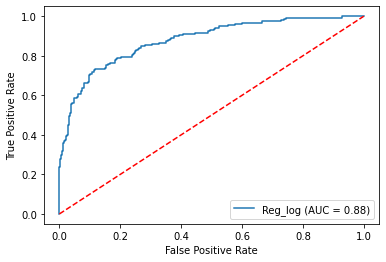

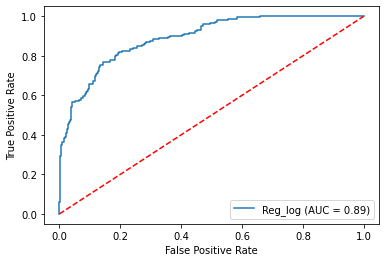

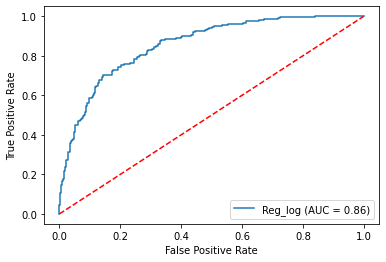

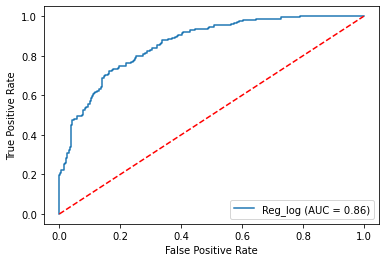

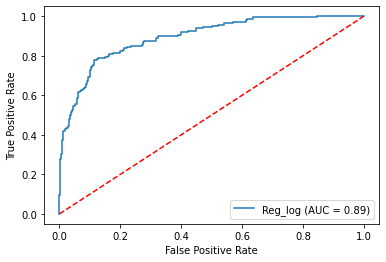

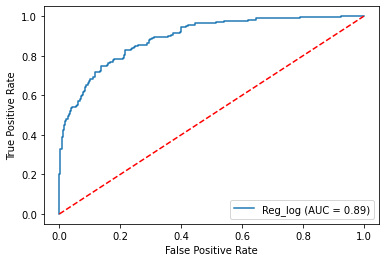

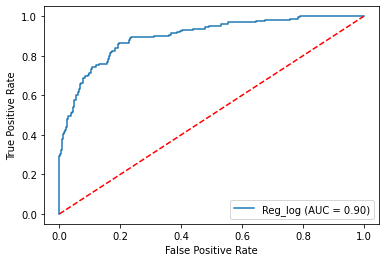

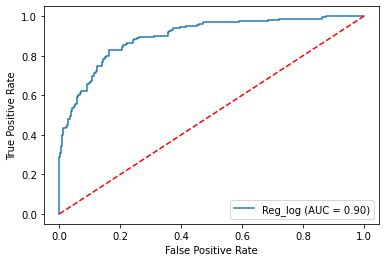

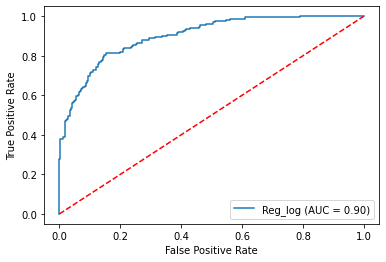

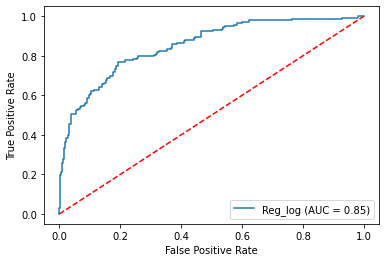

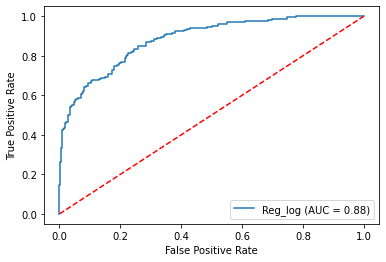

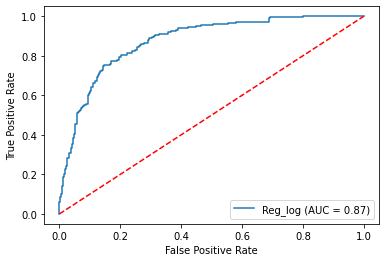

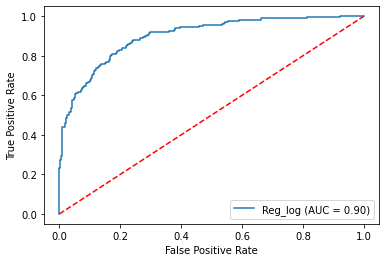

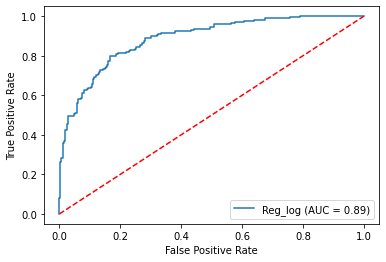

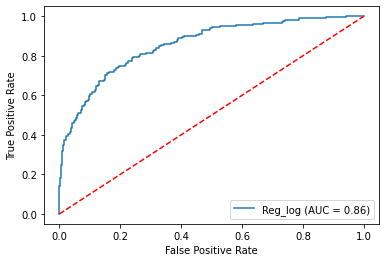

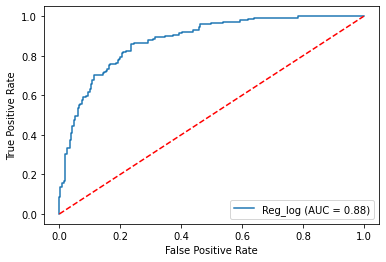

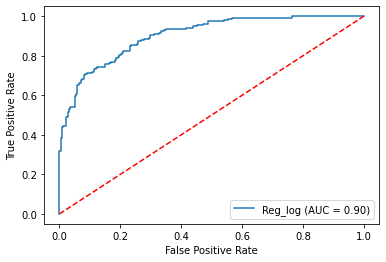

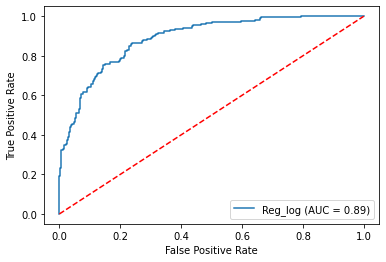

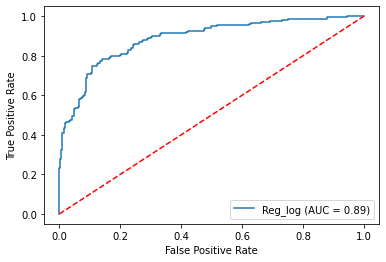

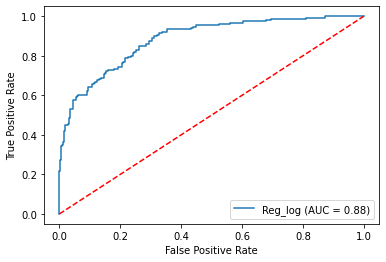

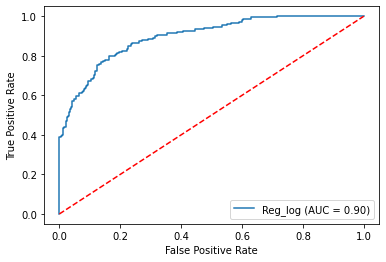

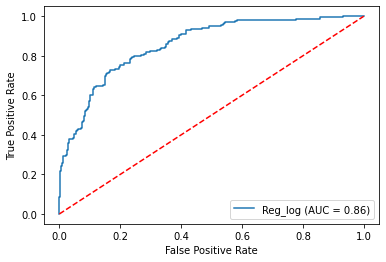

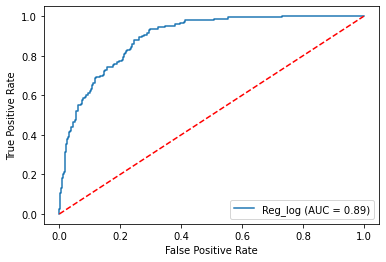

El minimo error es  0.17538203592814372  y se da con un parametro de  100.0


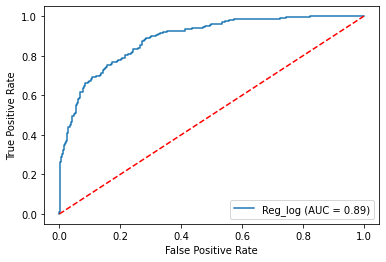

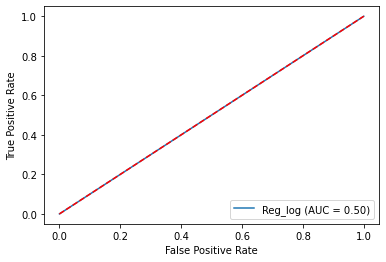

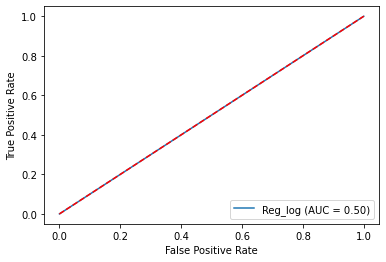

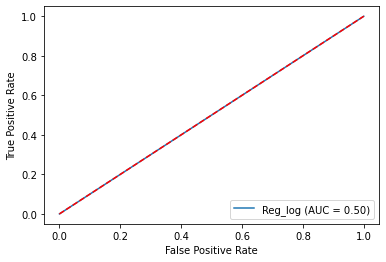

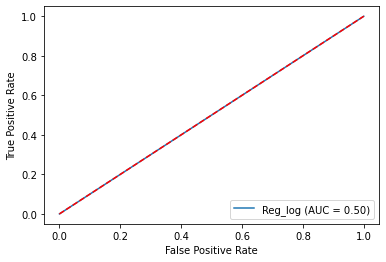

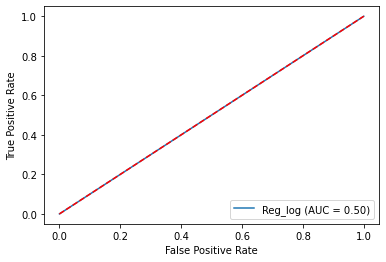

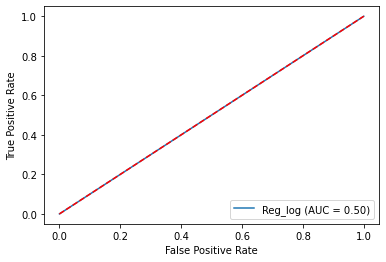

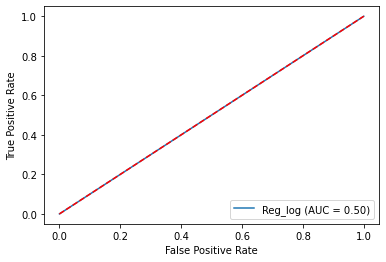

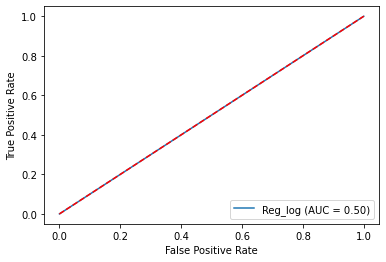

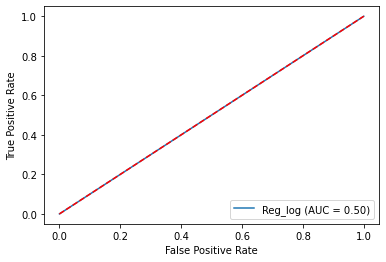

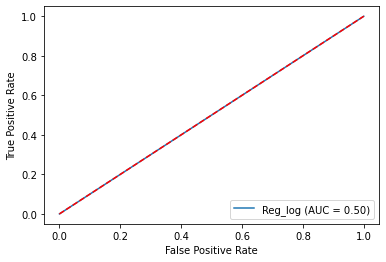

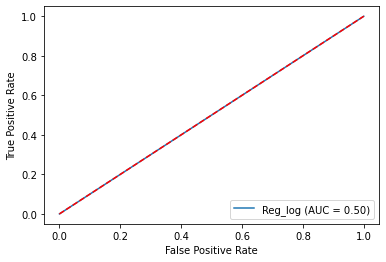

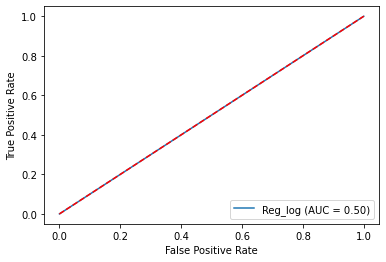

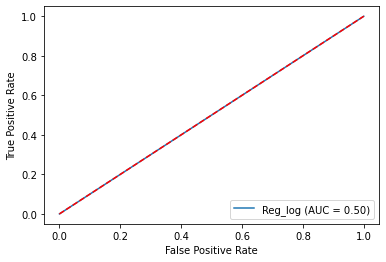

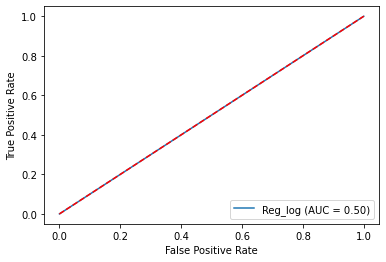

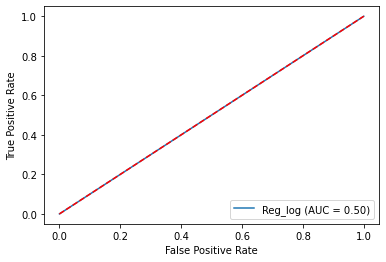

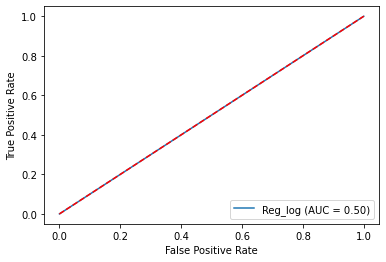

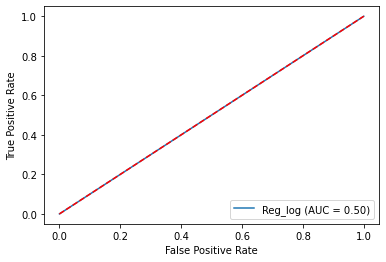

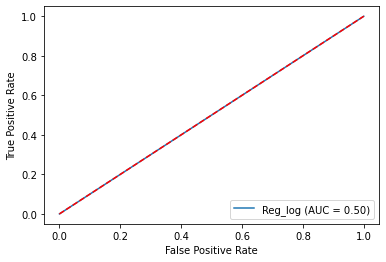

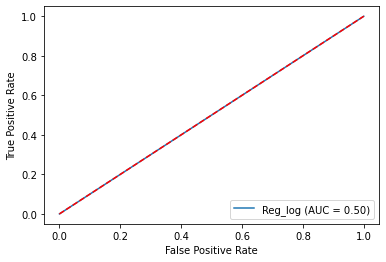

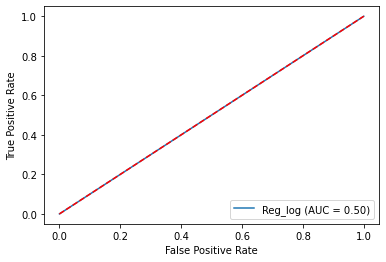

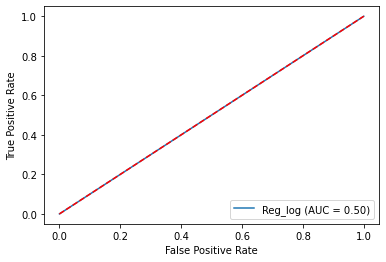

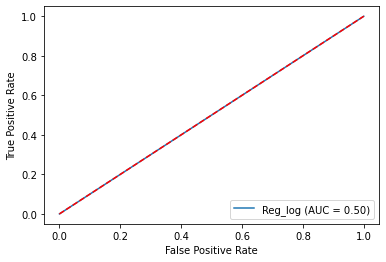

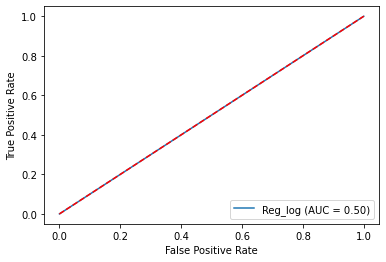

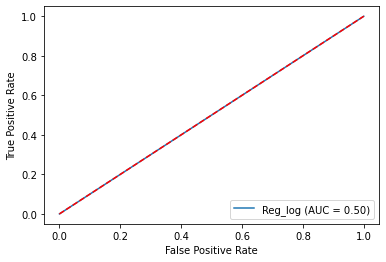

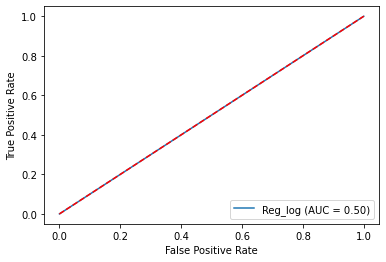

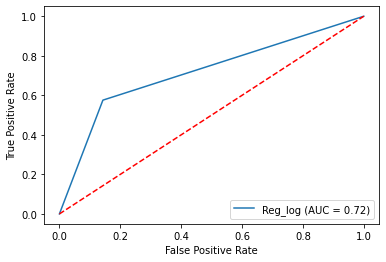

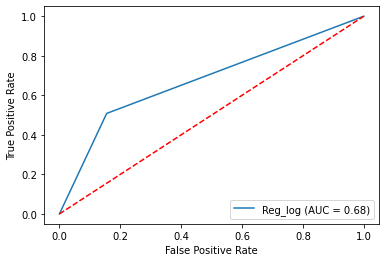

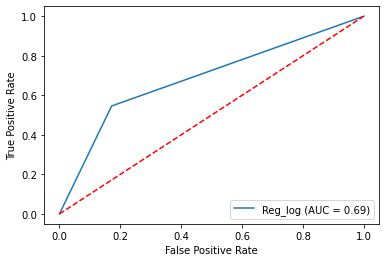

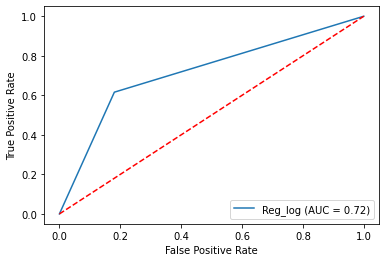

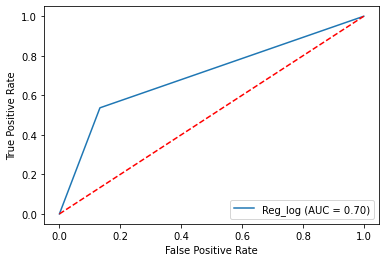

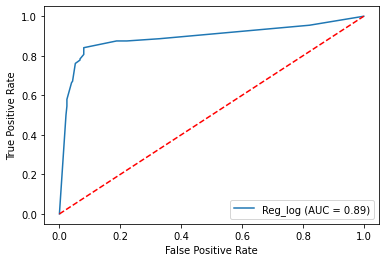

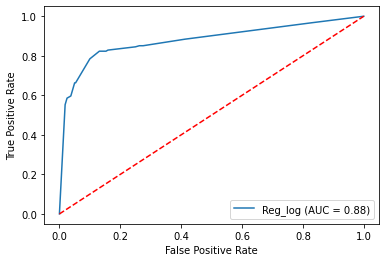

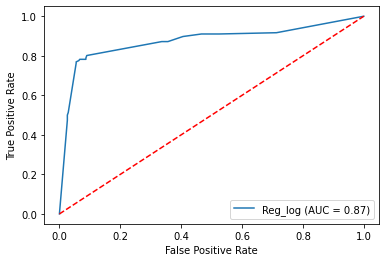

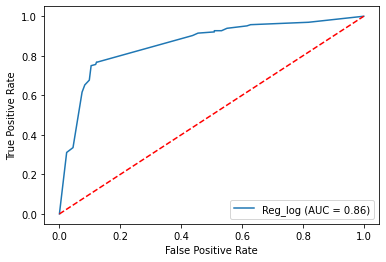

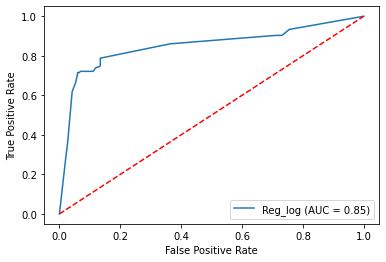

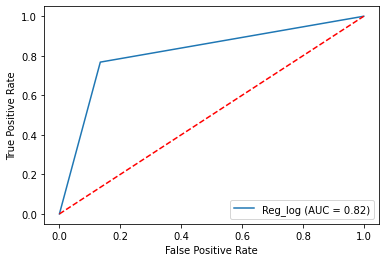

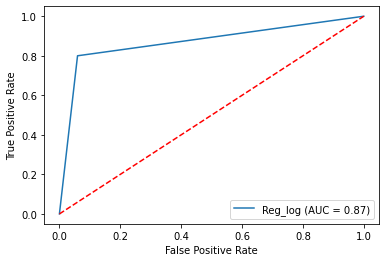

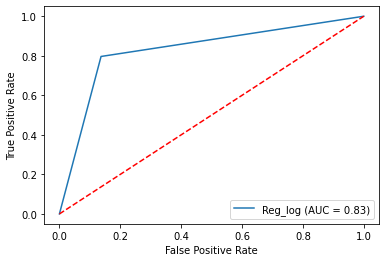

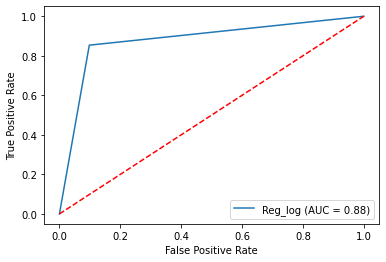

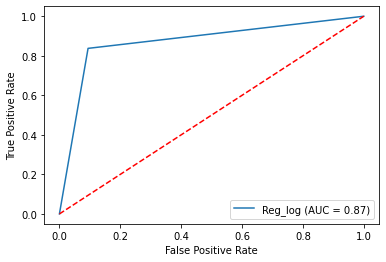

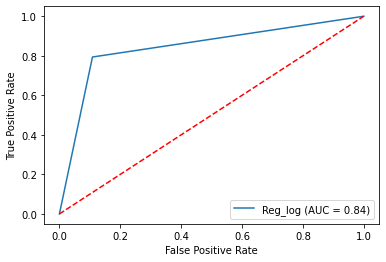

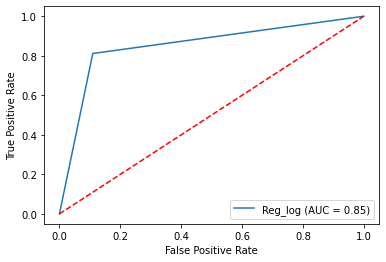

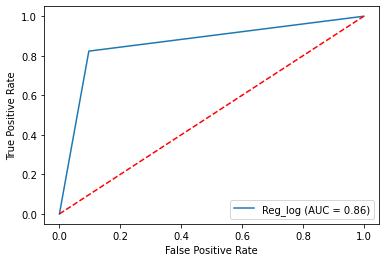

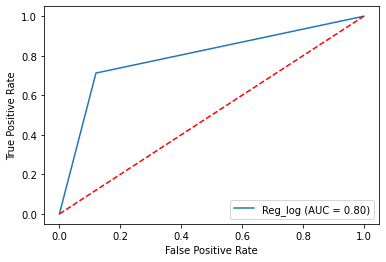

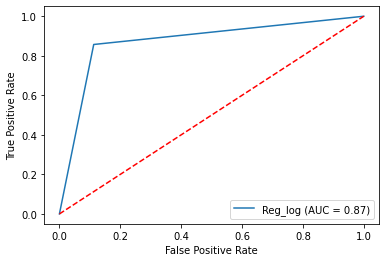

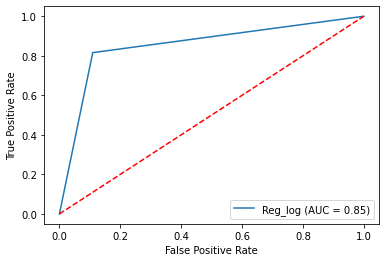

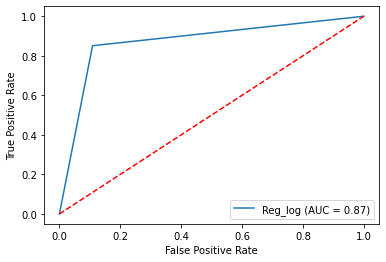

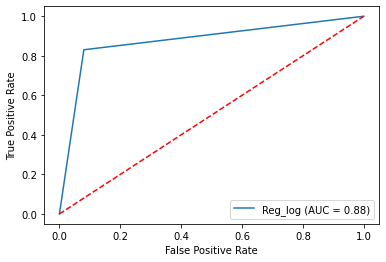

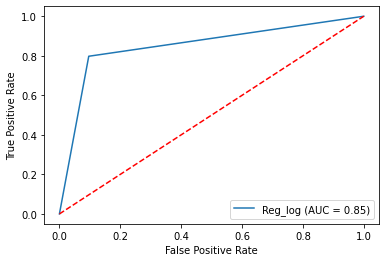

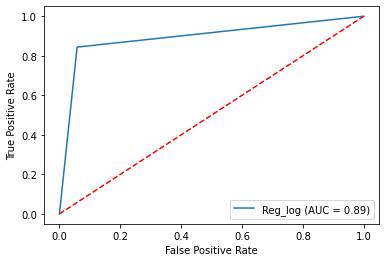

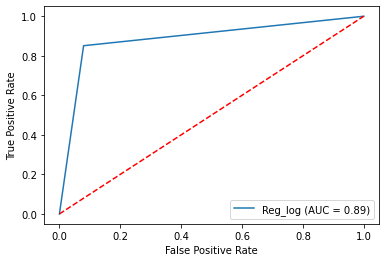

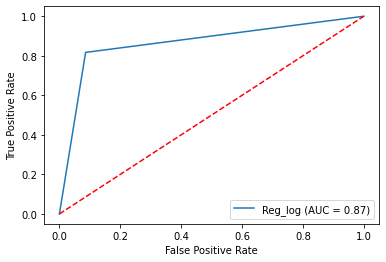

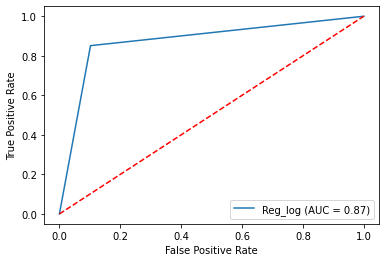

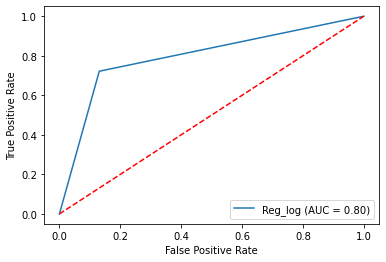

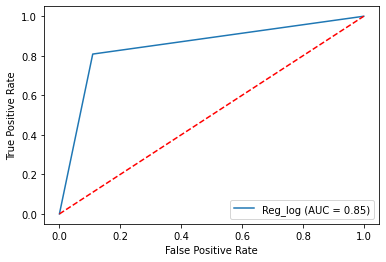

El minimo error es  0.11825309381237525  y se da con un parametro de  10000.0


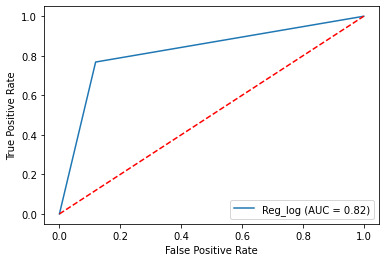

El minimo error es  0.2173453093812375  y se da con un parametro de  100.0


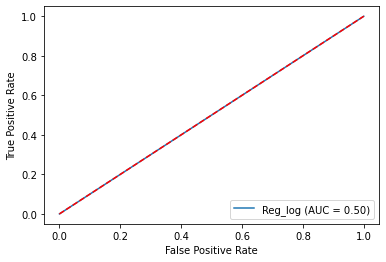

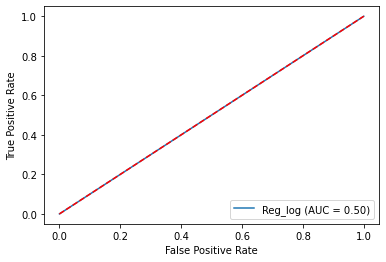

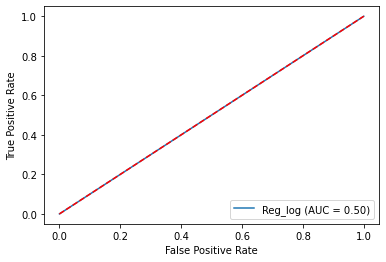

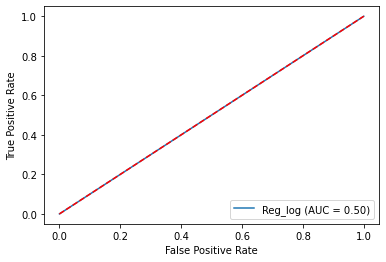

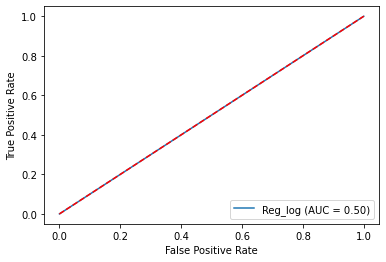

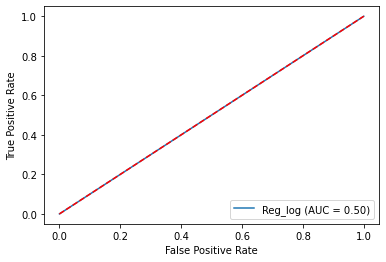

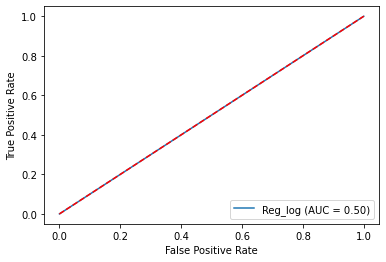

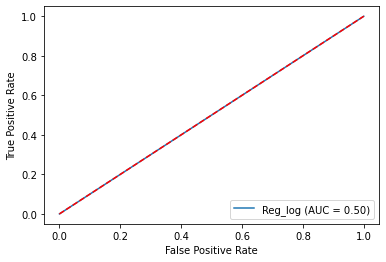

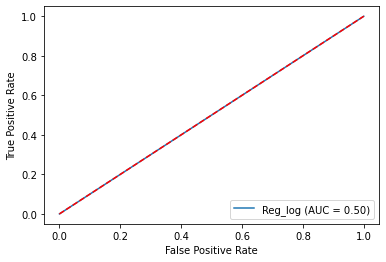

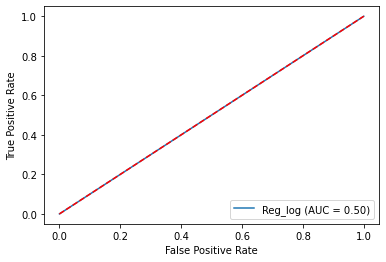

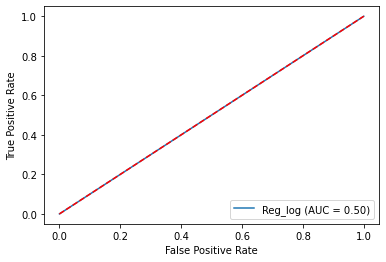

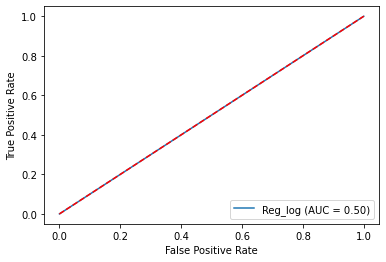

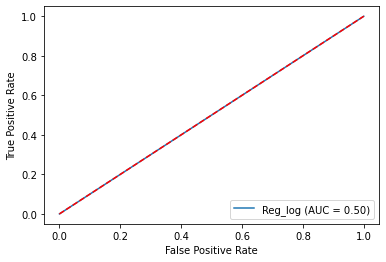

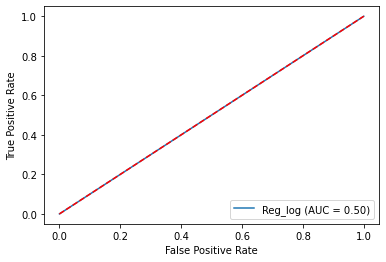

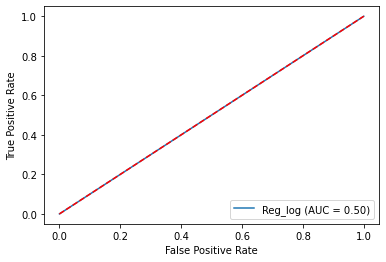

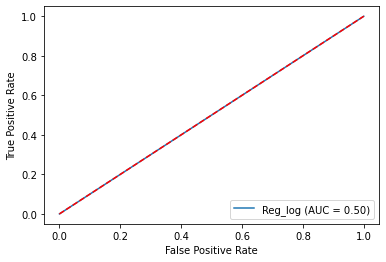

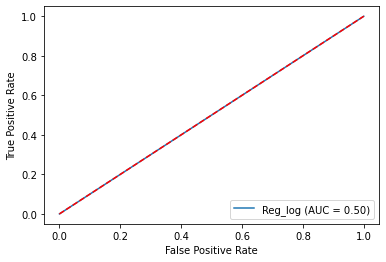

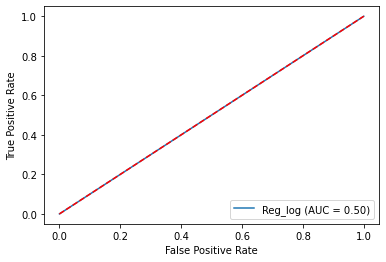

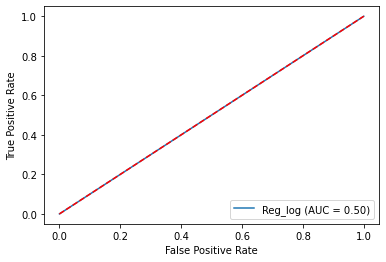

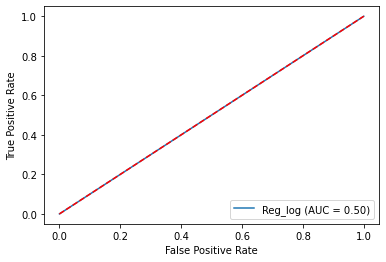

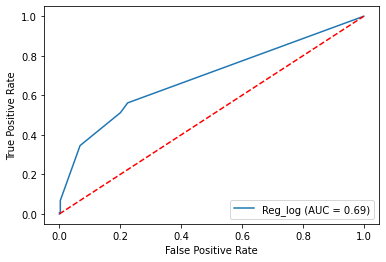

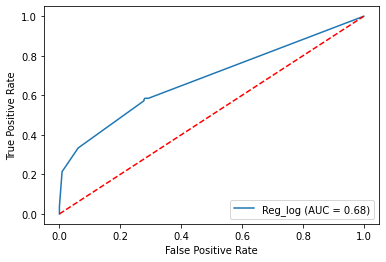

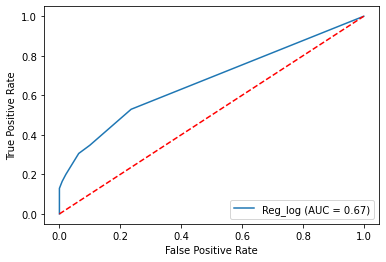

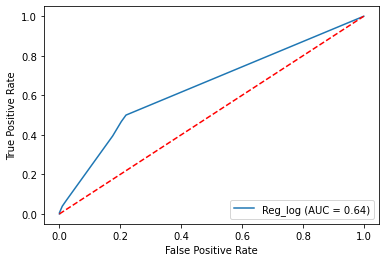

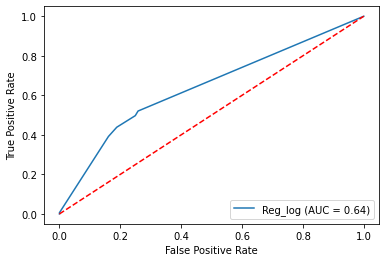

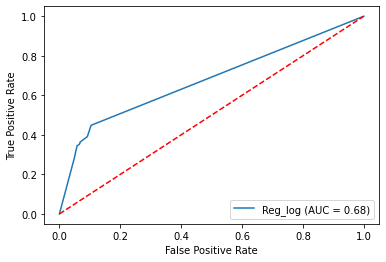

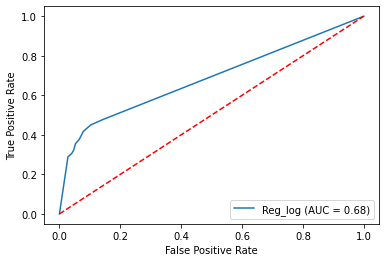

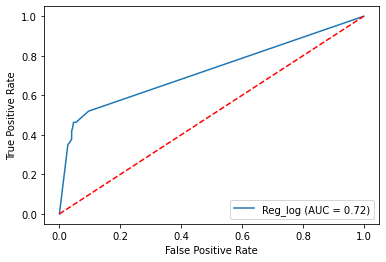

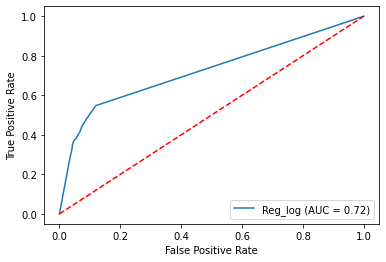

KeyboardInterrupt: 

In [239]:
lista = 10**np.linspace(-5,5,11)
todo, promedio, mejor = evalua_multiples_metodos(lista, respondieronx, respondieron["pobre"], 5)

## 3

In [21]:
mejor

,modelo,ecm,parámetro,auc,accuracy,fpr,tpr
0,Lineal,0.197071,100.0,0.860638,0.802929,"[0.0, 0.0, 0.0, 0.00202020202020202, 0.0020202...","[0.0, 0.00390625, 0.12890625, 0.12890625, 0.22..."
0,KNN,0.280959,15.0,0.761761,0.719041,"[0.0, 0.0, 0.0020491803278688526, 0.0040983606...","[0.0, 0.0076045627376425855, 0.015209125475285..."
0,Logit,0.174434,100.0,0.878208,0.825566,"[0.0, 0.0, 0.0, 0.0020408163265306124, 0.00204...","[0.0, 0.0038314176245210726, 0.137931034482758..."
0,CART,0.173103,100.0,0.807253,0.826897,"[0.0, 0.13253012048192772, 1.0]","[0.0, 0.7470355731225297, 1.0]"
0,SVM,0.231691,10.0,NaN,0.768309,NaN,NaN
0,Bagging,0.202397,10000.0,0.852271,0.797603,"[0.0, 0.03143418467583497, 0.06679764243614932...","[0.0, 0.3925619834710744, 0.47520661157024796,..."
0,RandomForest,0.127830,100000.0,0.932036,0.872170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.007722007722007722, 0.0115830115830115..."
0,Boosting,0.079893,10.0,0.969579,0.920107,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019841269841...","[0.0, 0.06882591093117409, 0.10121457489878542..."
0,Lasso,0.191744,10.0,0.858634,0.808256,"[0.0, 0.0, 0.0, 0.001949317738791423, 0.001949...","[0.0, 0.004201680672268907, 0.0672268907563025..."
0,Ridge,0.203728,1.0,0.869533,0.796272,"[0.0, 0.0, 0.0, 0.001996007984031936, 0.001996...","[0.0, 0.004, 0.072, 0.072, 0.088, 0.088, 0.12,..."


El método que predice mejor es Boosting, dado que presenta el mínimo error cuadrático medio.

## 4

Logtamos mejorar las predicciones con respecto al TP3 dado que pasamos de un ecm 0.11 a uno de 0.079. 

## 5

In [240]:
# Partimos para poder aplicar la función.
X_train, X_test, y_train, y_test = train_test_split(respondieronx,respondieron["pobre"],test_size=0.3)

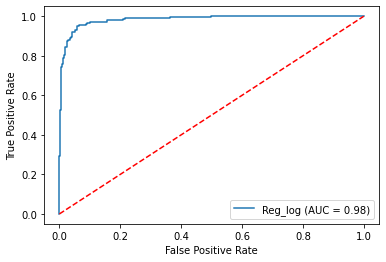

In [241]:
ult = GradientBoostingClassifier(learning_rate=1.0, max_depth = 10)
# Ajustamos el modelo        
ult = ult.fit(X_train, y_train)     
    
# Luego predecimos y con las X de evaluación.
y_pred = ult.predict(X_test)

# Probabilidad de que Y tome valor 1 segun el valor de X 
y_pred_proba = ult.predict_proba(X_test)[:,1]

#Valores de Accuracy
accuracy_pob = accuracy_score(y_test, y_pred)

#Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

#Valores de AUC
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#Curva ROC
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
def ROC(roc):
        display.plot()  
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.show()
ROC(display)

# Error cuadrático medio
        
ecm = mean_squared_error(y_pred, y_test)

In [242]:
y_pred_nr = ult.predict(norespondieron)
y_pred_nr.sum()
y_pred_nr.sum()/816

0.43137254901960786

El 43,13% de los hogares son pobres dentro de la base no respondieron. 